## Application: Wave Damage To Cargo Ships
---

#### Variables:

+ type - type: "A" to "E".
+ year - year of construction: 1960–64, 65–69, 70–74, 75–79 (coded as "60", "65", "70", "75").
+ period - period of operation : 1960–74, 75–79.
+ service - aggregate months of service.
+ incidents - number of damage incidents.

#### Source:

ships - Ships Damage Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

McCullagh, P. and J. A. Nelder (1983) *Generalized Linear Models*, Second Edition, Chapman & Hall, Table 6.2, Page 205.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from IPython.display import display

We consider the Poisson regression model:

\begin{align*}
 & \log(\text{expected number of damage incidents}) \\
 & = \beta_0 + \beta_1\log(\text{service}) + \beta_2(\text{ship type is B}) + \beta_3(\text{ship type is C}) + \beta_4(\text{ship type is D})+ \beta_5(\text{ship type is E}) \\
 & \quad + \beta_6(\text{year of construction: 1965-69}) + \beta_7(\text{year of construction: 1970-74})
    + \beta_8(\text{year of construction: 1975-79}) \\
 & \quad + \beta_9(\text{year of operation: 1975-79}).
\end{align*}


In [2]:
data = pd.read_csv('ships.csv', index_col=0)

We exclude the observations with `service` = 0.

In [3]:
data = data[data['service'] > 0]
log_service = np.log(data['service'].values).reshape((data.shape[0], 1))

Here we create dummy variables for ship types. The dummy variable for "A" is excluded.

In [4]:
str_type = data['type'].unique()
dummy_type = np.zeros((data.shape[0], str_type.size - 1))
for idx, ship_type in enumerate(str_type[1:]):
    dummy_type[:, idx] = (data['type'] == ship_type).values

Then we create dummy variables for years of construction. The dummy variable for 1960-64 is excluded.

In [5]:
str_year = data['year'].unique()
dummy_year =  np.zeros((data.shape[0], str_year.size - 1))
for idx, construction_year in enumerate(str_year[1:]):
    dummy_year[:, idx] = (data['year'] == construction_year).values

We create the dummy variable for period of operation.

In [6]:
str_period = data['period'].unique()
dummy_period =  np.zeros((data.shape[0], str_period.size - 1))
for idx, operation_period in enumerate(str_period[1:]):
    dummy_period[:, idx] = (data['period'] == operation_period).values

Finally we create the matrix of the independent variables `X` and the vector of the dependent variable `y`.

In [7]:
X = np.hstack((np.ones((data.shape[0],1)), log_service, dummy_type, dummy_year, dummy_period))
y = data['incidents'].values
var_names = ['constant', 'log_service', 'B', 'C', 'D', 'E', '65-69', '70-74', '75-79', 'operation']

In [8]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y)

In [9]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with poisson_regression_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123, return_inferencedata=False)
    results = az.summary(trace)
results.index = var_names
sim_param = dict([(var, trace['b'][:, index]) for index, var in enumerate(var_names)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 66 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8321621112001057, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
display(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
constant,-5.623,0.877,-7.210,-3.938,0.013,0.009,4378.0,4378.0,4382.0,6631.0,1.0
log_service,0.904,0.103,0.707,1.091,0.002,0.001,4603.0,4603.0,4601.0,6771.0,1.0
B,-0.342,0.274,-0.864,0.171,0.003,0.002,6509.0,6509.0,6505.0,8878.0,1.0
C,-0.792,0.341,-1.423,-0.142,0.003,0.002,10085.0,9579.0,10134.0,9815.0,1.0
D,-0.154,0.299,-0.708,0.417,0.003,0.002,9690.0,8498.0,9725.0,10101.0,1.0
E,0.270,0.242,-0.201,0.714,0.002,0.002,9571.0,8923.0,9561.0,10362.0,1.0
65-69,0.663,0.153,0.369,0.947,0.002,0.001,6648.0,6648.0,6620.0,10397.0,1.0
70-74,0.762,0.177,0.427,1.096,0.002,0.002,5786.0,5786.0,5777.0,9233.0,1.0
75-79,0.361,0.245,-0.086,0.833,0.003,0.002,6162.0,6162.0,6154.0,9408.0,1.0
operation,0.371,0.118,0.151,0.594,0.001,0.001,10725.0,10667.0,10717.0,11405.0,1.0


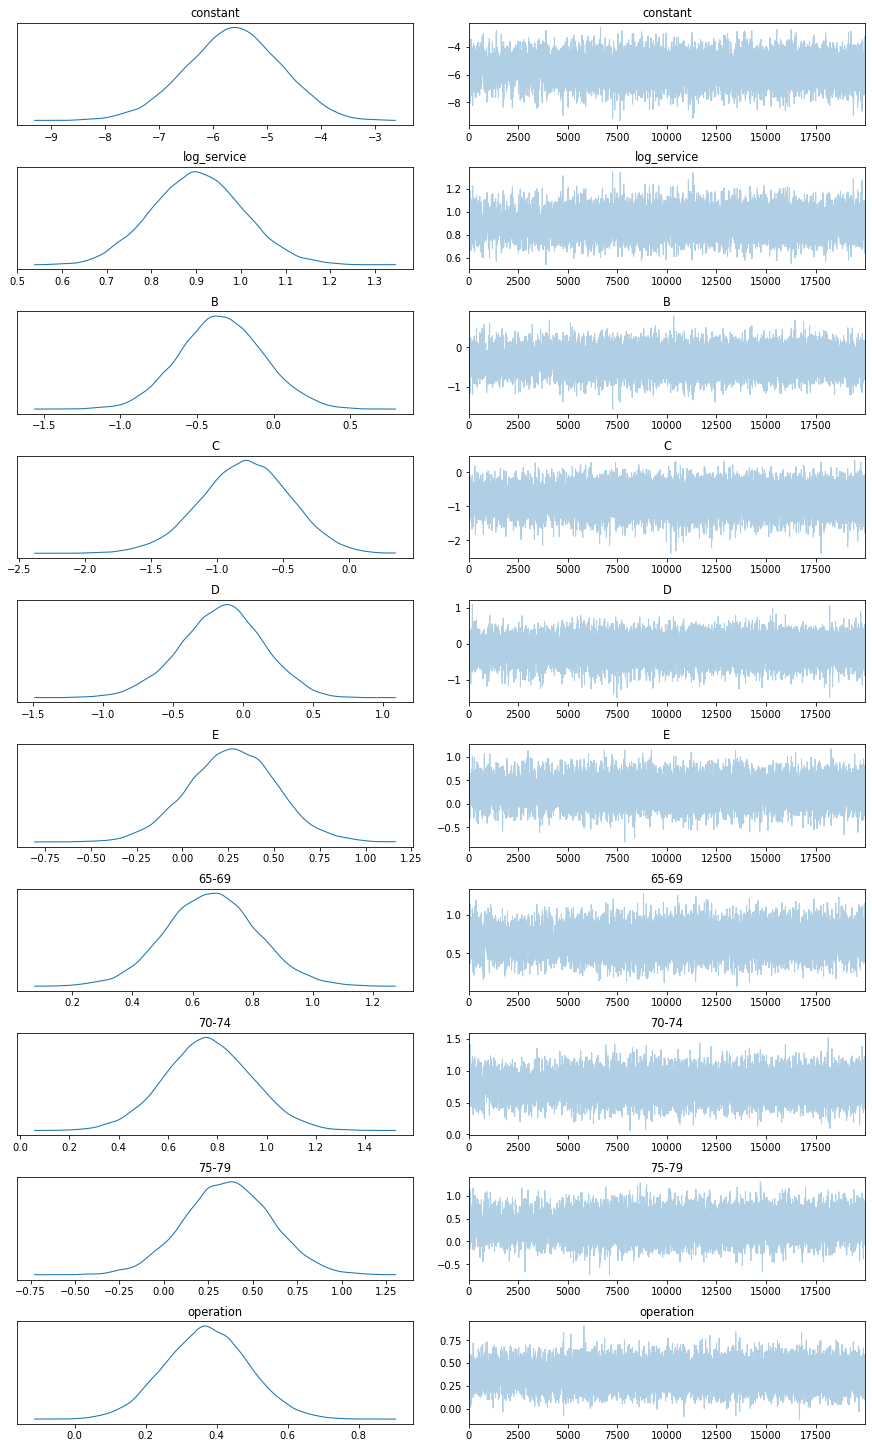

In [11]:
az.plot_trace(sim_param)
plt.show()

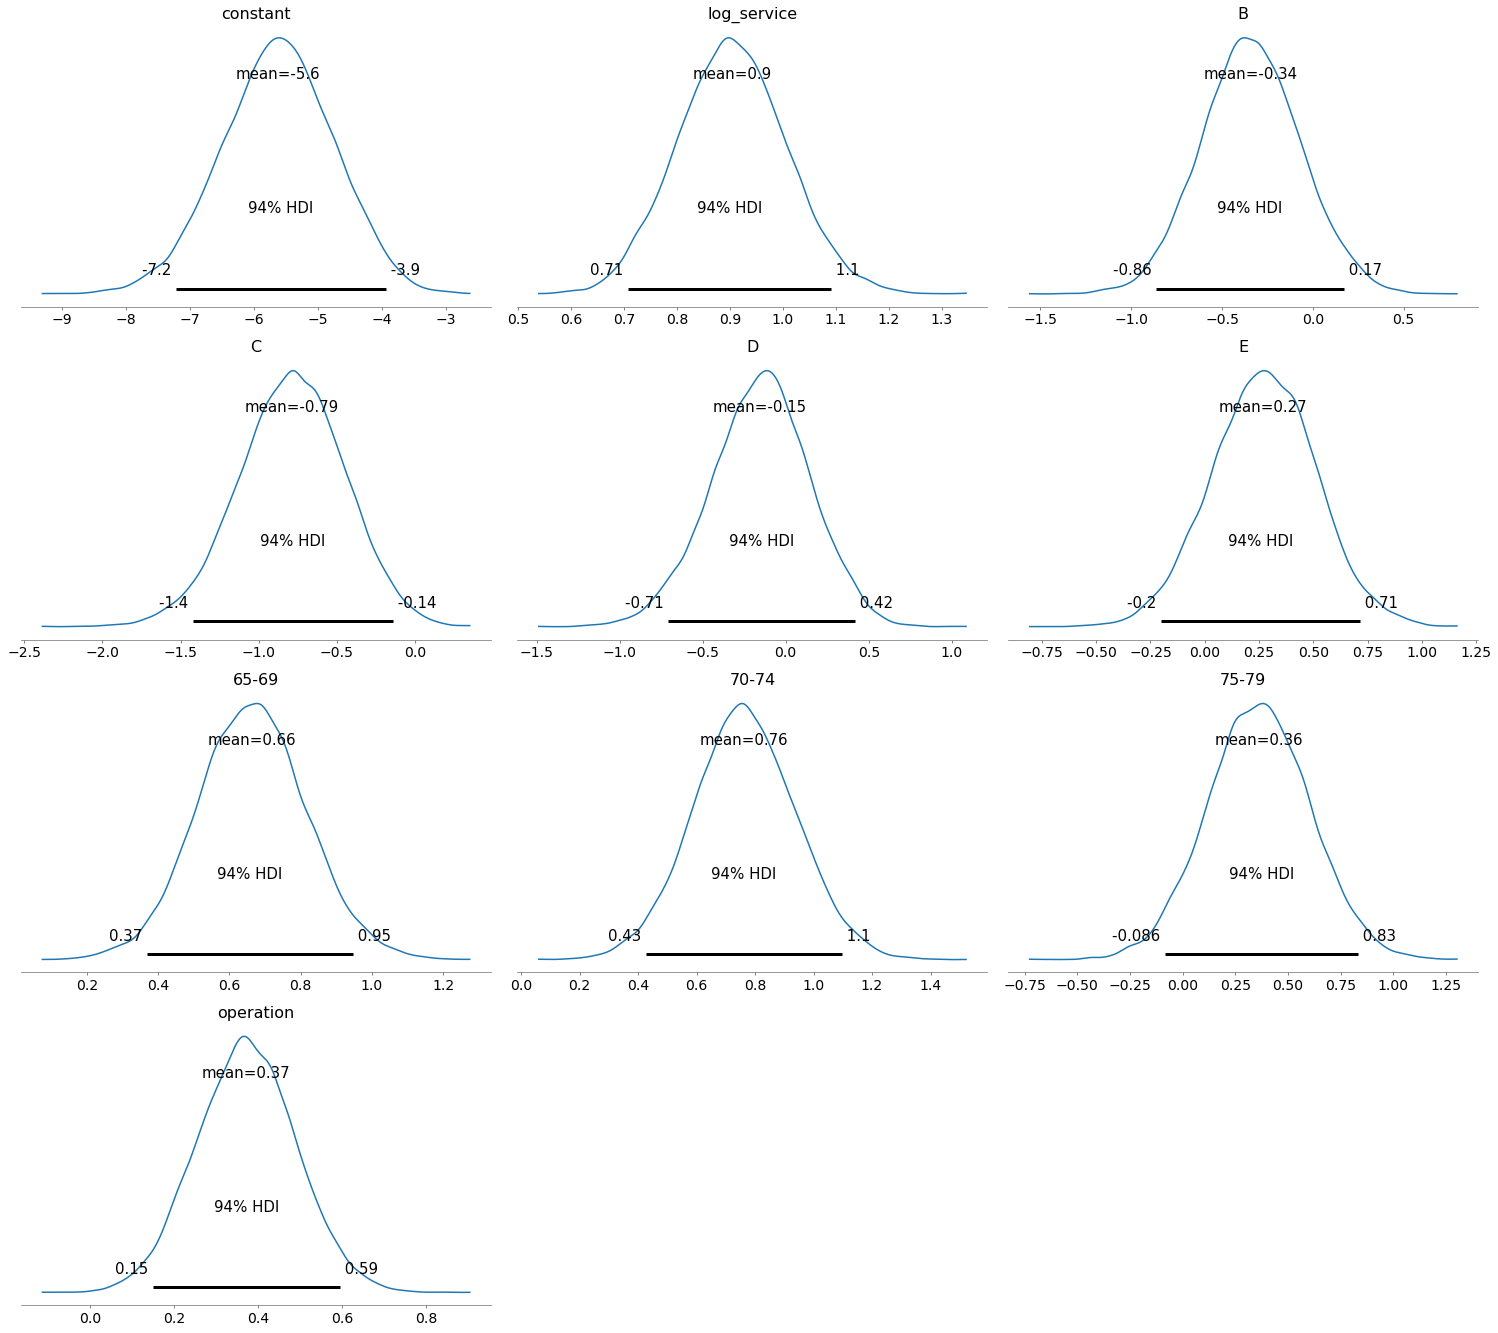

In [12]:
az.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()